# 🍽️ Simulasi Kantin IT Del

In [10]:
!pip install simpy numpy pandas seaborn matplotlib tqdm



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import simpy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

sns.set_style("whitegrid")                    # berbeda dari versi sebelumnya
sns.set_palette("husl")                       # warna cerah & modern
plt.rcParams["figure.figsize"] = (12, 5)


## 🎛️ Parameter Dasar Simulasi Kantin

In [12]:
jumlah_meja = 60
orang_per_meja = 3
jumlah_petugas = 7

TOTAL_OMPRENG = jumlah_meja * orang_per_meja

params = {
    "Jumlah Meja": jumlah_meja,
    "Orang per Meja": orang_per_meja,
    "Total Ompreng": TOTAL_OMPRENG,
    "Jumlah Petugas": jumlah_petugas,
    "Lauk (detik)": "30–60",
    "Angkat (detik)": "20–60",
    "Nasi (detik)": "30–60"
}

pd.DataFrame(params, index=[0])


,Jumlah Meja,Orang per Meja,Total Ompreng,Jumlah Petugas,Lauk (detik),Angkat (detik),Nasi (detik)
0,60,3,180,7,30–60,20–60,30–60


In [13]:
event_log = []

def log_event(stage, time, item):
    event_log.append([stage, time, item])


## 🔧 Proses Setiap Ompreng

In [14]:


def proses_kantin(env, nama, petugas):
    log_event("Mulai", env.now, nama)

    # Tahap 1: Lauk
    with petugas.request() as req:
        yield req
        yield env.timeout(np.random.uniform(30, 60))
        log_event("Lauk Selesai", env.now, nama)

    # Tahap 2: Angkat
    with petugas.request() as req:
        yield req
        yield env.timeout(np.random.uniform(20, 60))
        log_event("Angkat Selesai", env.now, nama)

    # Tahap 3: Nasi
    with petugas.request() as req:
        yield req
        yield env.timeout(np.random.uniform(30, 60))
        log_event("Nasi Selesai", env.now, nama)

    log_event("Selesai Semua", env.now, nama)


In [15]:
def jalankan_simulasi(total, petugas_count):
    env = simpy.Environment()
    petugas = simpy.Resource(env, capacity=petugas_count)

    for i in tqdm(range(total), desc="Memproses Ompreng"):
        env.process(proses_kantin(env, f"Ompreng-{i+1}", petugas))

    env.run()
    return pd.DataFrame(event_log, columns=["Tahap", "Waktu", "Ompreng"])


df = jalankan_simulasi(TOTAL_OMPRENG, jumlah_petugas)
df.head()


Memproses Ompreng:   0%|          | 0/180 [00:00<?, ?it/s]

,Tahap,Waktu,Ompreng
0,Mulai,0.0,Ompreng-1
1,Mulai,0.0,Ompreng-2
2,Mulai,0.0,Ompreng-3
3,Mulai,0.0,Ompreng-4
4,Mulai,0.0,Ompreng-5


## 📊 Visualisasi: Heatmap Tahapan Proses Kantin

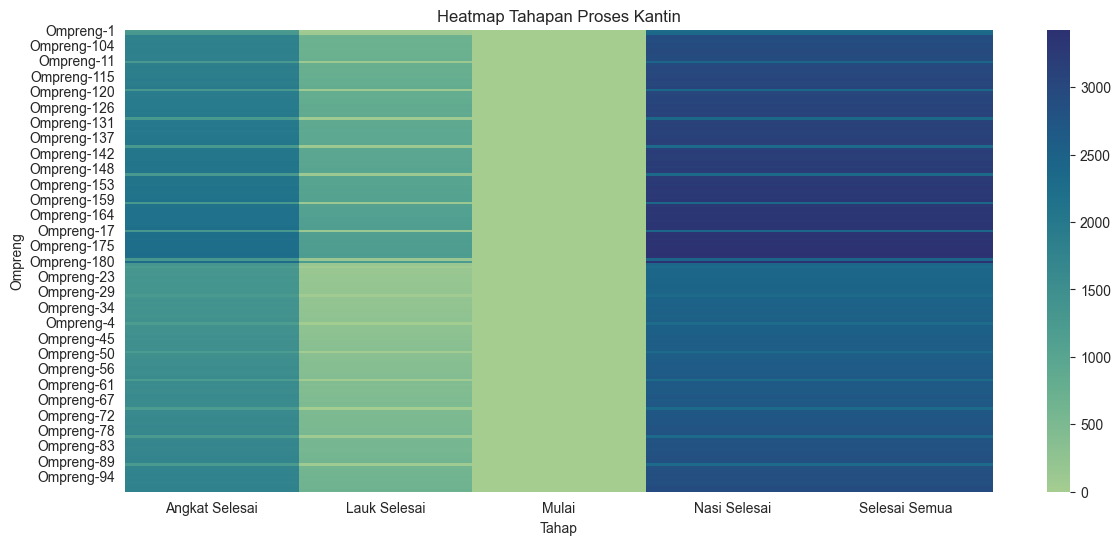

In [16]:
heat = df.pivot_table(values="Waktu", index="Ompreng", columns="Tahap")

plt.figure(figsize=(14, 6))
sns.heatmap(heat, cmap="crest")
plt.title("Heatmap Tahapan Proses Kantin")
plt.show()


## 📈 Distribusi Durasi (KDE Plot)

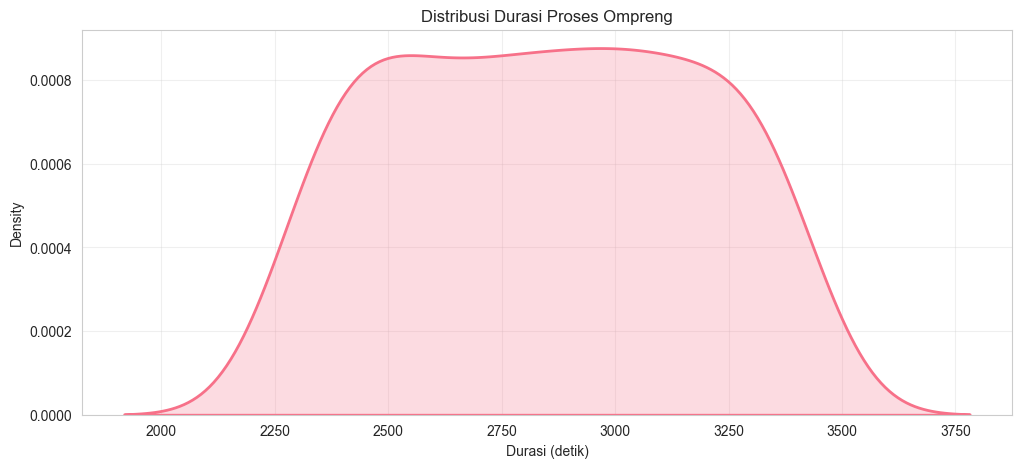

In [17]:
durasi = heat["Selesai Semua"] - heat["Mulai"]

plt.figure(figsize=(12, 5))
sns.kdeplot(durasi, fill=True, linewidth=2)
plt.title("Distribusi Durasi Proses Ompreng")
plt.xlabel("Durasi (detik)")
plt.grid(True, alpha=0.3)
plt.show()


## 📊 Jumlah Event per Tahapan Proses


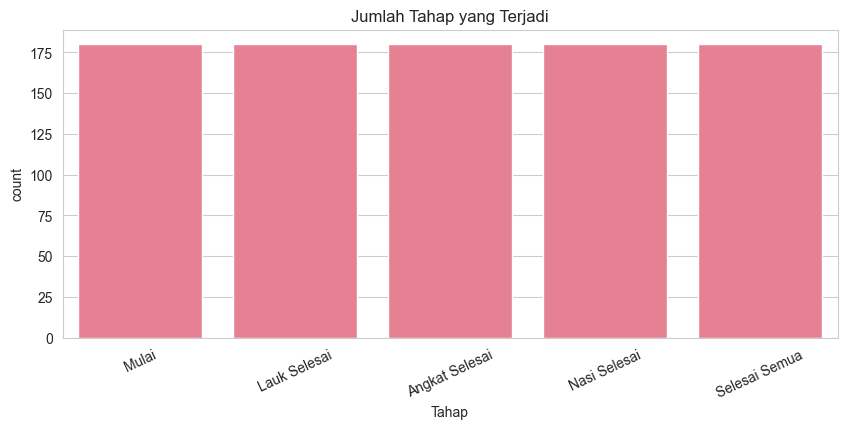

In [18]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x="Tahap")
plt.title("Jumlah Tahap yang Terjadi")
plt.xticks(rotation=25)
plt.show()


## 🧾 Statistik Ringkas Simulasi Kantin


In [19]:
stat = {
    "Jumlah Ompreng": len(durasi),
    "Rata-Rata Durasi (detik)": durasi.mean(),
    "Durasi Tercepat (detik)": durasi.min(),
    "Durasi Terlama (detik)": durasi.max()
}

pd.DataFrame(stat, index=["Hasil"])


,Jumlah Ompreng,Rata-Rata Durasi (detik),Durasi Tercepat (detik),Durasi Terlama (detik)
Hasil,180,2847.18663,2273.081408,3426.592428
